# Sommaire
* [I.Introduction](#section1)
* [II.Chargement des bibliothèques](#section2)
* [III.Présentation des différentes fonctions](#section3)
* [IV.Features Engineering](#section4)
* [V.Construction d'un modèle sans tenir compte du déséquilibre du target](#section5)
* [VI.Application de méthodes de rééchantillonnage pour pallier au déséquilibre des données](#section6)
* [VII. Features importance](#section7)

# I.Introduction:<a name="section1"></a> 

# Data

Les données sont fournies par Home Credit [Home Credit](http://www.homecredit.net/about-us.aspx), un service dédié à l'octroi de lignes de crédit (prêts) à la population non bancarisée. L'objectif est de prédire si le client remboursera un prêt ou aura des difficultés est un besoin commercial critique,




![image](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)


application_{train|test}.csv


    Il s'agit de la table principale, divisée en deux fichiers pour Train (avec TARGET) et Test (sans TARGET).
    Données statiques pour toutes les applications. Une ligne représente un prêt dans notre échantillon de données.

bureau.csv

    Tous les crédits antérieurs des clients fournis par d'autres institutions financières qui ont été signalés au bureau de crédit (pour les clients qui ont un prêt dans notre échantillon).
    Pour chaque prêt de notre échantillon, il y a autant de lignes que le nombre de crédits que le client avait dans le bureau de crédit avant la date de la demande.
    
bureau_balance.csv

    Soldes mensuels des crédits précédents dans Credit Bureau.
    Ce tableau a une ligne pour chaque mois d'historique de chaque crédit précédent signalé au bureau de crédit - c'est-à-dire que le tableau a (#prêts dans l'échantillon * # de crédits précédents relatifs * # de mois où nous avons un historique observable pour les crédits précédents) lignes .


POS_CASH_balance.csv

    Instantanés du solde mensuel des précédents POS (points de vente) et des prêts en espèces que le demandeur avait avec Home Credit.
    Ce tableau a une ligne pour chaque mois d'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau a (#prêts dans l'échantillon * # de crédits précédents relatifs * # de mois dans laquelle nous avons un historique observable pour les crédits précédents).

credit_card_balance.csv

    Instantanés du solde mensuel des cartes de crédit précédentes que le demandeur a avec Home Credit.
    Ce tableau a une ligne pour chaque mois d'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau a (#prêts dans l'échantillon * # de cartes de crédit précédentes relatives * # de mois où nous avons un historique observable pour les lignes de carte de crédit précédentes).


previous_application.csv

    Toutes les demandes précédentes de crédit immobilier des clients ayant des crédits dans notre échantillon.
    Il y a une ligne pour chaque demande précédente liée aux prêts dans notre échantillon de données.
    
installments_payments.csv

    Historique de remboursement des crédits précédemment décaissés en Crédit Logement relatifs aux crédits de notre échantillon.
    Il y a a) une ligne pour chaque paiement effectué plus b) une ligne pour chaque paiement manqué.
    Une ligne équivaut à un versement d'une échéance OU une échéance correspondant à un versement d'un précédent crédit Home Credit lié aux crédits de notre échantillon.


https://www.kaggle.com/ganeshn88/home-credit-model

# II.Chargement des bibliothèques<a name="section2"></a>


In [40]:
import sys

#numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

from collections import Counter

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#Data Preprocessing
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import imblearn

#Model building
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# import xgboost as xgb
# from xgboost.sklearn import XGBClassifier
# import lightgbm as lgb

#Model Evaluation

from sklearn.metrics import roc_auc_score

#Saving Models
#from sklearn.externals import joblib

In [41]:
print("pandas version", pd.__version__)
print("numpy version", np.__version__) 
print("python version", sys.version)
print("matplotlib version", matplotlib.__version__)
print("seaborn version", sns.__version__)
print("sklearn", sklearn.__version__)
print("imblearn", imblearn.__version__)

pandas version 1.2.4
numpy version 1.20.1
python version 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
matplotlib version 3.3.4
seaborn version 0.11.1
sklearn 0.24.1
imblearn 0.8.0


In [42]:
# List files available
path = "../notebook python/projet 7/csv/"
print(os.listdir(path))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


# III Présentation des différentes fonctions<a name="section3"></a>

**Réduction de l'utilisation de la mémoire**

In [43]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {: .2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

**Importation des données**

In [44]:
def importdata():    
    print('-' * 80)
    print('train')
    train = import_data(path+'application_train.csv')

    print('-' * 80)
    print('test')
    test = import_data(path+'application_test.csv')

    print('-' * 80)
    print('bureau_balance')
    bureau_balance = import_data(path+'bureau_balance.csv')

    print('-' * 80)
    print('bureau')
    bureau = import_data(path+'bureau.csv')

    print('-' * 80)
    print('credit_card_balance')
    credit_card = import_data(path+'credit_card_balance.csv')

    print('-' * 80)
    print('installments_payments')
    installments = import_data(path+'installments_payments.csv')

    print('-' * 80)
    print('pos_cash_balance')
    pos_cash = import_data(path+'POS_CASH_balance.csv')

    print('-' * 80)
    print('previous_application')
    previous_app = import_data(path+'previous_application.csv')
    return train, test, bureau_balance, bureau, credit_card, installments, pos_cash, previous_app

**Récupération des listes de colonnes de type numérique et de type catégorie**

In [45]:
def getListe_type_columns (df):
    list_categ = []
    list_num = []
    for col in df.columns:
        col_type = df[col].dtype
        if df[col].dtype.name in ["category", "object"]:
            list_categ.append(col)
        else:
            list_num.append(col)
    return list_categ, list_num

# IV. Feature Engineering<a name="section4"></a>

In [46]:
def featureengineering(df):
        
   
    df = df[df['CODE_GENDER'] != 'XNA']
    
    df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
    
    docs = [_f for _f in df.columns if 'FLAG_DOC' in _f]
    live = [_f for _f in df.columns if ('FLAG_' in _f) & ('FLAG_DOC' not in _f)]

    df['NEW_DOC_IND_AVG'] = df[docs].mean(axis = 1)
    df['NEW_DOC_IND_STD'] = df[docs].std(axis = 1)
    df['NEW_DOC_IND_KURT'] = df[docs].kurtosis(axis = 1)

    df['NEW_LIVE_IND_SUM'] = df[live].sum(axis = 1)
    df['NEW_LIVE_IND_STD'] = df[live].std(axis = 1)
    df['NEW_LIVE_IND_KURT'] = df[live].kurtosis(axis = 1)

    df['NEW_CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL'] # ratio montant du crédit du prêt /revenu du client
    df['NEW_CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE'] # ratio montant du crédit du prêt/ prix des biens pour lesquels le crédit est accordé
    df['NEW_ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL'] # ratio rente de prêt(annuité) /revenu du client
    df['NEW_ANNUITY_TO_CREDIT_RATIO'] = df['AMT_ANNUITY'] / df['AMT_CREDIT'] # ratio rente de prêt (annuité) / montant du crédit du prêt
    df['NEW_INCOME_TO_CREDIT_RATIO'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT'] # ratio revenu du client/ montant du crédit du prêt
    df['NEW_INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS'] # ratio revenu du client / nb de personnes de la famille du client
    df['NEW_DAYS_EMPLOY_AGE_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH'] # ratio combien de jours avant la demande le client a commencé son emploi actuel / combien de jours avant la demande le client est-il né 
    df['NEW_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['NEW_EXT_SOURCES_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    df['NEW_SCORES_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    df['NEW_SCORES_STD'] = df['NEW_SCORES_STD'].fillna(df['NEW_SCORES_STD'].mean())
    
    return df


# V. Construction du modèle sans tenir compte du déséquilibre du Target<a name="section5"></a>

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

def construct_pipe(categorical_features, numeric_features, model):
    numeric_transformer = Pipeline(steps=[
                                         ('imputer', SimpleImputer(strategy = 'median')),
                                         ('scaler', MinMaxScaler(feature_range = (0, 1)))])

    # categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')
    categorical_transformer = Pipeline(steps = [
                                         ('imputer', SimpleImputer(strategy = 'most_frequent')),
                                         ('onehot', OneHotEncoder(handle_unknown='ignore')
                                         )])
    preprocessor = ColumnTransformer(
                                     transformers = [
                                     ('cat', categorical_transformer, categorical_features),
                                     ('num', numeric_transformer, numeric_features)
                                     
                                                  ])

    clf = Pipeline(steps = [('preprocessor', preprocessor),
                      ('classifier', model)])
    return clf

In [52]:
def preprocess_buildmodel(train, test, cvtype):
    
    train = featureengineering(train)
    test = featureengineering(test)
    
    
    y = train["TARGET"]

    X = train.drop(["TARGET"], axis = 1)

    categorical_features, numeric_features = getListe_type_columns (X)

    

    
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 1)
    
    models = {'lr': LogisticRegression()}
   
    params = {'lr': {"classifier__C": np.logspace(-3, 3, 7), "classifier__penalty":["l2"]}}  
  
    models = {'lr': LogisticRegression()}
    
    from collections import defaultdict
    
    model_result = defaultdict(list)
    
    for key in models.keys():
        
        model = models[key]
        param = params[key]
        pipe = construct_pipe(categorical_features, numeric_features, model)
        
        if cvtype == 'grid':
            clf=GridSearchCV(pipe ,param, cv = 5, verbose = 0)
        elif cvtype == 'rand':
            clf = RandomizedSearchCV(pipe, param, random_state = 1, n_iter = 100, cv = 5, verbose = 0, n_jobs = -1)
    
    clf.fit(X_train, y_train)
        
    print("tuned hpyerparameters :(best parameters) ", clf.best_params_)
    print("accuracy :", clf.best_score_)
        
    
    aucscoretr = roc_auc_score(y_train, clf.predict_proba(X_train)[: , 1])
    aucscore = roc_auc_score(y_test, clf.predict_proba(X_test)[: , 1])
    print("roc_auc :", aucscore)

    model_result[key] = clf, clf.best_estimator_.get_params(), aucscoretr, aucscore 
        
    return model_result, X_train, X_test, y_train, y_test
    

**Exécution** 

**Importation de toutes les données**

In [53]:
train, test, bureau_balance, bureau, credit_card, installments, pos_cash, previous_app = importdata()

--------------------------------------------------------------------------------
train
Memory usage of dataframe is  286.23 MB
Memory usage after optimization is: 59.54 MB
Decreased by 79.2%
--------------------------------------------------------------------------------
test
Memory usage of dataframe is  45.00 MB
Memory usage after optimization is: 9.40 MB
Decreased by 79.1%
--------------------------------------------------------------------------------
bureau_balance
Memory usage of dataframe is  624.85 MB
Memory usage after optimization is: 156.21 MB
Decreased by 75.0%
--------------------------------------------------------------------------------
bureau
Memory usage of dataframe is  222.62 MB
Memory usage after optimization is: 78.57 MB
Decreased by 64.7%
--------------------------------------------------------------------------------
credit_card_balance
Memory usage of dataframe is  673.88 MB
Memory usage after optimization is: 263.69 MB
Decreased by 60.9%
----------------------

**Construction du modèle avec seulement Application_Data**

In [54]:

# model_result, X_train, X_test, Y_train, Y_test, test_scaled, columns = preprocess_buildmodel(train, test,'grid')
model_result, X_train, X_test, y_train, y_test = preprocess_buildmodel(train, test,'rand')

tuned hpyerparameters :(best parameters)  {'classifier__penalty': 'l2', 'classifier__C': 0.1}
accuracy : 0.9193715574886688
roc_auc : 0.7478955301326524


**Combinaison des données importées**

In [55]:
# Days 365.243 values -> nan
previous_app['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace = True)
previous_app['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace = True)
previous_app['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace = True)
previous_app['DAYS_LAST_DUE'].replace(365243, np.nan, inplace = True)
previous_app['DAYS_TERMINATION'].replace(365243, np.nan, inplace = True)
# Add feature: value ask / value received percentage
previous_app['APP_CREDIT_PERC'] = previous_app['AMT_APPLICATION'] / previous_app['AMT_CREDIT']
#
prev_apps_avg = previous_app.groupby('SK_ID_CURR').mean()
prev_apps_avg.columns = ['p_' + col for col in prev_apps_avg.columns]
#//

data = train.append(test)
train_prev_app = data.merge(right = prev_apps_avg.reset_index(), how ='left', on='SK_ID_CURR')


avg_inst = installments.groupby('SK_ID_CURR').mean()
avg_inst.columns = ['i_' + f_ for f_ in avg_inst.columns]
train_prev_app_inst = train_prev_app.merge(right=avg_inst.reset_index(), how = 'left', on = 'SK_ID_CURR')

pos_cash = pos_cash.groupby('SK_ID_CURR').mean()
train_prev_app_inst_pos = train_prev_app_inst.merge(right = pos_cash.reset_index(), how ='left', on = 'SK_ID_CURR')

avg_cc_bal = credit_card.groupby('SK_ID_CURR').mean()
avg_cc_bal.columns = ['cc_bal_' + f_ for f_ in avg_cc_bal.columns]
train_prev_app_inst_pos_credit = train_prev_app_inst_pos.merge(right = avg_cc_bal.reset_index(), how = 'left', on = 'SK_ID_CURR')

# ajout 
bureau_balance_avg = bureau_balance.groupby("SK_ID_BUREAU").mean()
bureau_balance_avg.columns = ['BB_' + f_ for f_ in bureau_balance_avg.columns]
bureau_bb =  bureau.merge(right = bureau_balance_avg, how = "left", on = "SK_ID_BUREAU")
bureau_bb.drop(['SK_ID_BUREAU'], axis = 1, inplace = True)
bureau_bb
#
bureau_avg = bureau_bb.groupby('SK_ID_CURR').mean()
bureau_avg.columns = ['B_' + f_ for f_ in bureau_avg.columns]
train_prev_app_inst_pos_credit_bureau = train_prev_app_inst_pos_credit.merge(right = bureau_avg.reset_index(), how = 'left', on = 'SK_ID_CURR')


In [56]:
app_train = train_prev_app_inst_pos_credit_bureau[train_prev_app_inst_pos_credit_bureau['SK_ID_CURR'].isin(train.SK_ID_CURR)]

app_test = train_prev_app_inst_pos_credit_bureau[train_prev_app_inst_pos_credit_bureau.SK_ID_CURR.isin(test.SK_ID_CURR)]
app_test.drop('TARGET', axis = 1, inplace = True)
#

In [57]:
app_train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'B_DAYS_ENDDATE_FACT', 'B_AMT_CREDIT_MAX_OVERDUE',
       'B_CNT_CREDIT_PROLONG', 'B_AMT_CREDIT_SUM', 'B_AMT_CREDIT_SUM_DEBT',
       'B_AMT_CREDIT_SUM_LIMIT', 'B_AMT_CREDIT_SUM_OVERDUE',
       'B_DAYS_CREDIT_UPDATE', 'B_AMT_ANNUITY', 'B_BB_MONTHS_BALANCE'],
      dtype='object', length=190)

## Exécution du modèle sans tenir compte du déséquilibre des données

In [58]:
train_prev_app_inst_pos_credit_bureau.replace([np.inf, -np.inf], np.nan, inplace=True)

app_train = train_prev_app_inst_pos_credit_bureau[train_prev_app_inst_pos_credit_bureau['SK_ID_CURR'].isin(train.SK_ID_CURR)]

app_test = train_prev_app_inst_pos_credit_bureau[train_prev_app_inst_pos_credit_bureau["SK_ID_CURR"].isin(test.SK_ID_CURR)]
app_test.drop('TARGET', axis = 1, inplace = True)


#
print('Shape', app_train.shape)
model_result, X_train, X_test, y_train, y_test = preprocess_buildmodel(app_train, app_test, 'rand')

Shape (307511, 190)
tuned hpyerparameters :(best parameters)  {'classifier__penalty': 'l2', 'classifier__C': 10.0}
accuracy : 0.9195260258937827
roc_auc : 0.7599515799802145


In [59]:
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

clf = model_result['lr'][0]

print("accuracy :", clf.score(X_test, y_test))        
    
aucscoretr = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
aucscore = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print("roc_auc :", aucscore)


predicts = clf.predict(X_train)
confusion_matrix(y_train, predicts)

accuracy : 0.9196286299632532
roc_auc : 0.7599515799802145


array([[225937,    208],
       [ 19600,    260]], dtype=int64)

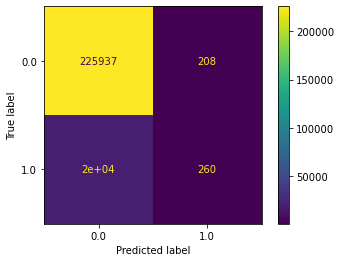

In [60]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, X_train, y_train) 

In [61]:
from sklearn.metrics import precision_score, recall_score, classification_report

print("Precision:", precision_score(y_train, predicts))
print("Recall:", recall_score(y_train, predicts))

Precision: 0.5555555555555556
Recall: 0.013091641490433032


Le recall c'est la proportion de positif que l'on a correctement identifié.
La précision c'est la proportion de prédiction correcte parmi les points que l'on a prédit positif.

In [62]:
print(classification_report(y_train, predicts))

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96    226145
         1.0       0.56      0.01      0.03     19860

    accuracy                           0.92    246005
   macro avg       0.74      0.51      0.49    246005
weighted avg       0.89      0.92      0.88    246005



## Courbe ROC

Text(0.5, 1.0, 'ROC Curve on the Test Set')

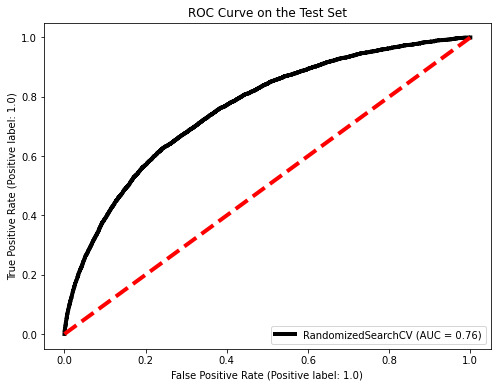

In [63]:
from sklearn import metrics

fig, ax = plt.subplots(figsize=(8, 6))
metrics.plot_roc_curve(clf, X_test, y_test, ax = ax, color = 'black', lw=4)
ax.plot([0, 1], linestyle = '--', lw = 4, color = 'red')
ax.set_title('ROC Curve on the Test Set')


Plus la courbe bleue penche vers le coin supérieur gauche (angle droit), mieux un modèle prédit les résultats réels.

Les problèmes de classification sur données déséquilibrées sont des problèmes dans lesquels les classes à prédire ne sont pas représentées de façon égale. En raison de ce déséquilibre de classe nous avons peu d'exemples de la classe minoritaire (classe positive) sur lesquels apprendre. L'algorithme d'apprentissage est donc biaisé du côté de la classe majoritaire (classe négative) et donc les prédictions sont moins robustes que lorsqu'il n'y a pas de déséquilibre.

Le problème ici est de choisir une bonne métrique d'évaluation pour mesurer la performance d'un problème prédictif. Nous allons donc regarder la matrice de confusion permettant de visualiser les prédictions justes et les prédictions fausses.

Une matrice de confusion se présente de la manière suivante :
![image](https://miro.medium.com/max/724/1*13QHc83W7tWSluLe7k3RsA.png)

où 

* Vrai positif ou TP - un résultat où le modèle prédit correctement la classe positive
* Faux positif ou FP (bien connu sous le nom d' erreur de type I ) - un résultat où le modèle prédit de manière incorrecte la classe positive
* Vrai négatif ou TN - un résultat où le modèle prédit correctement la classe négative
* Faux négatif ou FN (bien connu sous le nom d' erreur de type II ) - un résultat où le modèle prédit de manière incorrecte la classe négative

et les métriques d'évaluation les plus usités sont :
* Précision - un rapport entre l'observation correctement prédite et le total des observations
* Rappel ou sensibilité - un rapport entre les observations positives correctement prédites et toutes les observations de la classe réelle - positif
* Spécificité - un rapport d'observations négatives correctement prédites à toutes les observations de la classe réelle - négatif
* Précision - un rapport des observations positives correctement prédites au total des observations positives prévues



Il faut dans un premier temps se méfier de l'exactitude ou accuracy car elle ne tient pas compte de la distribution des données. Avec un jeu de données de deux classes, où la première classe représente 90% des données, si le classifieur prédit que chaque exemple appartient à la première classe, l’exactitude sera de 90%, mais ce classifieur est inutile dans la pratique.

D’autres métriques sont plus pertinentes dans le cas du déséquilibre de classes.

* La précision pour minimiser le taux d’erreurs parmi les exemples prédits positifs par le modèle
* Le rappel pour tenter de détecter un maximum de positif
* Le F1-score pour trouver un compromis entre la précision et le rappel. Lorsqu’il est aussi coûteux de manquer un positif que de déclarer un faux positif

Dans notre cas, on voit bien que l'accuracy est de 0.91, mais que le recall est très mauvais 0.01 et la précision de 0.54


# VI. Application de méthodes de rééchantillonnage pour pallier au déséquilibre des données<a name="section6"></a>

## Utilisation des méthodes de rééchantillonnage

Modifier l’ensemble de données que vous utilisez avant d’entraîner votre modèle prédictif afin d’avoir des données plus équilibrées.

Cette stratégie est appelée rééchantillonnage et il existe deux méthodes principales que nous pouvons utiliser pour égaliser les classes : 

Le sur-échantillonnage : Oversampling et le sous-échantillonnage :Undersampling. 

* Les méthodes d’Oversampling fonctionnent en augmentant le nombre d’observations de la (des) classe(s) minoritaire(s) afin d’arriver à un ratio classe minoritaire/ classe majoritaire satisfaisant.

* Les méthodes d’Undersampling fonctionnent en diminuant le nombre d’observations de la  (des) classe(s) majoritaire(s) afin d’arriver à un ratio classe minoritaire/ classe majoritaire satisfaisant.


* Il faut privilégier le sous-échantillonnage lorsque l'on dispose de grands jeux de données : des dizaines ou des centaines de milliers de cas ou plus.
* Il faut privilégiez le sur-échantillonnage lorsque l'on ne dispose pas de beaucoup de données :des dizaines de milliers ou moins.

In [64]:
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import SMOTE 
import imblearn
import sklearn
    
def preprocess_buildmodel_reechanch(train, test, cvtype, reech = False):
    
    train = featureengineering(train)
    test = featureengineering(test)
    
    
   
    y = train["TARGET"]

    X = train.drop(["TARGET"], axis = 1)

    categorical_features, numeric_features = getListe_type_columns (X)
    
   
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 1)
    
    
        
    models = {'lr': LogisticRegression()}
   
    params = {'lr': {"classifier__C": np.logspace(-3, 3, 7), "classifier__penalty":["l2"]}}  
  
    models = {'lr': LogisticRegression()}
    
    from collections import defaultdict
    
    model_result = defaultdict(list)
    
    for key in models.keys():
        
        model = models[key]
        param = params[key]
      
        
        numeric_transformer = Pipeline(steps=[
                                          ('imputer', SimpleImputer(strategy = 'median')),
                                          ('scaler', MinMaxScaler(feature_range = (0, 1)))])

        categorical_transformer = Pipeline(steps = [
                                         ('imputer', SimpleImputer(strategy = 'most_frequent')),
                                         ('onehot', OneHotEncoder(handle_unknown='ignore')
                                         )])
        preprocessor = ColumnTransformer(
                                      transformers=[
                                      ('cat', categorical_transformer, categorical_features),
                                      ('num', numeric_transformer, numeric_features)
                                     
                                                  ])

        
        if reech:
            samp = RandomUnderSampler()
        else:
            samp =  SMOTE(random_state=42) # SMOTE()
            
        pipe = imblearn.pipeline.Pipeline([
          ("preprocessor", preprocessor),
            ("sampler", samp),
            ("classifier", model)
          ])


        if cvtype == 'grid':
            clf=GridSearchCV(pipe ,param, cv = 5, verbose = 0)
        elif cvtype == 'rand':
            clf = RandomizedSearchCV(pipe, param, random_state = 1, n_iter = 100, cv = 5, verbose = 0, n_jobs = -1)
    
    clf.fit(X_train, y_train)
        
    print("tuned hpyerparameters :(best parameters) ", clf.best_params_)
    print("accuracy :", clf.best_score_)
     
    y_pred = clf.predict(X_test)
    #------------------------------------
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    #-----------------------------------
    print(classification_report_imbalanced(y_test, y_pred))
    
    aucscoretr = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
    aucscore = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    print("roc_auc :", aucscore)
    
    plot_confusion_matrix(clf, X_train, y_train)
    
    fig, ax = plt.subplots(figsize = (8, 6))
    metrics.plot_roc_curve(clf, X_test, y_test, ax = ax, color = 'black', lw = 4)
    ax.plot([0, 1], linestyle = '--', lw = 4, color = 'red')
    ax.set_title('ROC Curve on the Test Set')

    model_result[key] = clf, clf.best_estimator_.get_params(), aucscoretr, aucscore 
        
    return model_result, X_train, X_test, y_train, y_test
    

## La premiere méthode de surééchantillonage

tuned hpyerparameters :(best parameters)  {'classifier__penalty': 'l2', 'classifier__C': 100.0}
accuracy : 0.683368224223085
Precision: 0.16011568915651225
Recall: 0.6801611278952668
                   pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.69      0.68      0.80      0.68      0.47     56537
          1       0.16      0.68      0.69      0.26      0.68      0.47      4965

avg / total       0.90      0.69      0.68      0.76      0.68      0.47     61502

roc_auc : 0.7495325762392748


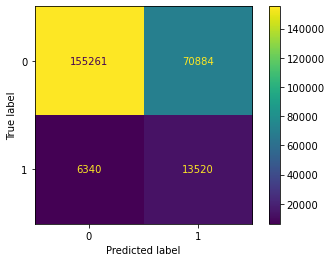

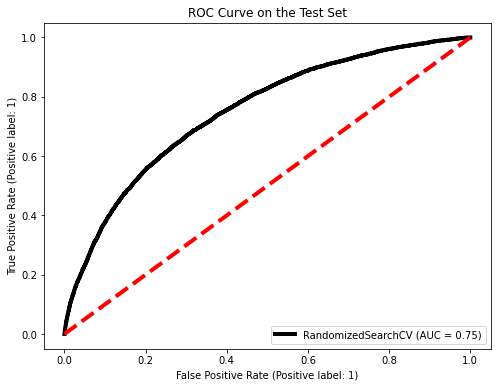

In [65]:
model_result, X_train, X_test, y_train, y_test = preprocess_buildmodel_reechanch(train, test, 'rand', True)

##  La génération d’échantillons synthétiques


Il existe des algorithmes pour générer des échantillons synthétiques de manière automatique. Le plus populaire de ces algorithmes est SMOTE (pour Synthetic Minority Over-sampling Technique). Comme son nom l’indique, SMOTE est une méthode de sur-échantillonnage. Elle fonctionne en créant des échantillons synthétiques à partir de la classe minoritaire au lieu de créer de simples copies. 


tuned hpyerparameters :(best parameters)  {'classifier__penalty': 'l2', 'classifier__C': 10.0}
accuracy : 0.6980874372472105
Precision: 0.1593613645378818
Recall: 0.6473313192346425
                   pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.70      0.65      0.81      0.67      0.46     56537
          1       0.16      0.65      0.70      0.26      0.67      0.45      4965

avg / total       0.89      0.70      0.65      0.76      0.67      0.46     61502

roc_auc : 0.7384848510919093


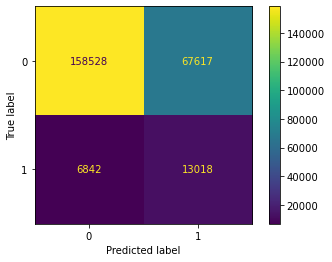

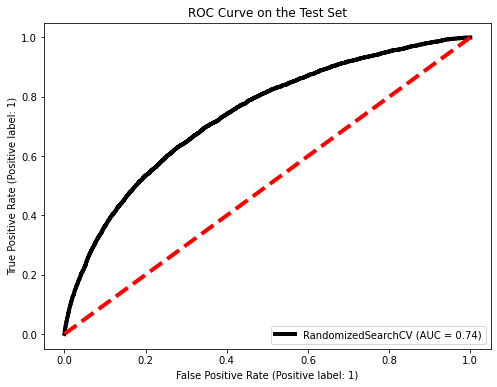

In [66]:
model_result, X_train, X_test, y_train, y_test = preprocess_buildmodel_reechanch(train, test, 'rand', False)


Cherchons à obtenir le seuil optimal. Partons de la courbe roc. identifions le seuil qui nous donne le coin supérieur gauche. Soit p le seuil, TPR le taux de vrais positifs, FPR le taux de faux positifs, l'équation suivante est satisfaite

\begin{aligned}{TPR(p) = 1-FPR(P)}\end{aligned}

On doit donc trouver le p tel que le taux de vrais positifs soit égal au taux de vrais négatifs. On recherche donc le seuil tel que :

\begin{aligned}{p^{*}=arg min_{p}​| TPR ( p )+FPR ( p )−1∣}\end{aligned}

Ce qui nous donne dans notre cas

In [67]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, model_result['lr'][0].best_estimator_.predict_proba(X_train)[:, 1],drop_intermediate = False)

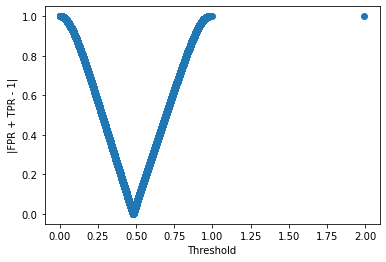

In [68]:
plt.scatter(thresholds,np.abs(fpr + tpr - 1))
plt.xlabel("Threshold")
plt.ylabel("|FPR + TPR - 1|")
plt.show()

In [69]:
thresholds[np.argmin(np.abs(fpr+tpr-1))]

0.48024734767101435

In [70]:
train = featureengineering(train)


In [71]:
import pickle
model = model_result['lr'][0].best_estimator_
tuple_objects = (model, X_test.sample(5000))

# Save tuple
pickle.dump(tuple_objects, open("tuple_model_lr.pkl", 'wb'))

Rappel :


* Classe majoritaire : Négatif ou sans événement affecté à l'étiquette de classe 0.
* Classe minoritaire : Positif ou événement auquel a été attribué le label de classe 1.


Une fois que nous avons appliqué la technique de rééchantillonnage, nous allons imposer un coût supplémentaire au modèle pour les erreurs de classifications faites sur la classe minoritaire. En effet toutes les erreurs de classification ne sont pas égales. Nous allons prendre en compte le coût des erreurs de prédiction. 


Ici par exemple:

Problème de prêt bancaire : la banque souhaite déterminer si elle doit ou non accorder un prêt à un client. Refuser un prêt à un bon client n'est pas aussi grave que d'accorder un prêt à un mauvais client qui ne le remboursera peut-être jamais.

Prédire spécifiquement les cas positifs en tant que cas négatifs est plus nocif, plus coûteux ou pire, quelle que soit la manière dont nous voulons mesurer le contexte du domaine cible.

Un client classé FN (un client réellement en défaut prédit client sans défaut) est plus coûteux qu'un client FP (client sans défaut prédit client avec défaut). On cherche donc à minimiser le nombre de clients FN et donc à maximiser le nombre de clients TP.

Rappelons que le  

\begin{aligned}{\text{Recall}}&={\frac {tp}{tp+fn}}\end{aligned} 

et la 

\begin{aligned}{\text{Précision}}&={\frac {tp}{tp+fp}}\end{aligned}

On cherche donc à maximiser le Recall.


Les divers coûts de classification erronée sont mieux compris en utilisant l'idée d'une matrice de coûts.

Matrice de coût : une matrice qui attribue un coût à chaque cellule de la matrice de confusion.

||Predicted Negative| Predicted Positive
|--|------|----------------------------
|Actual Negative | C(0,0), TN      | C(0,1), FP
|Actual Positive | C(1,0), FN      | C(1,1), TP


Une intuition de cette matrice est que le coût d'une mauvaise classification est toujours plus élevé que la classification correcte.
Nous obtenons 

\begin{aligned}{\text{Le Profit}}&={C(0,0)*TN+C(0,1)*FP+C(1,0)*FN+C(1,1)*TP}\end{aligned}


Ecrivons une matrice des coûts (en prenant des valeurs arbitraires) en fonction de ces données : 

||Prédicted(Class) Personne solvable|Predicted (Class) Personne non solvable|
|--|---------------------------------|---------------------------------------|
|Actual (Class) Personne solvable|TN, 1|   FP,0|
|Actual (Class) Personne non solvable| FN, -3|TP,0|

Faisons un graphique du profit en fonction du seuil
Nous obtenons donc le graphique suivant : 

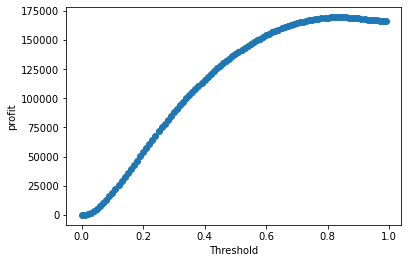

In [72]:
import numpy as np
from sklearn.metrics import accuracy_score

accuracy = []
profits = []
cout = []
for p in np.arange(0,1,0.01):
    y_pred = (model.predict_proba(X_train)[:,1] >= p).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
    profits.append(1*tn-3*fn)
    

plt.scatter(np.arange(0, 1, 0.01), profits)
plt.xlabel("Threshold")
plt.ylabel("profit")
plt.show()



In [73]:
thres = np.arange(0, 1, 0.01)
thres[np.argmax(profits)]

0.8200000000000001

Nous allons maintenant regarder l'importance des features de deux manières : 
- en premier en regardant les divers coefficients de la régression logistique
- en second en utilisant la librairie shap

# VII Features importance<a name="section7"></a>

Récupérons dans un premier temps, le nom de chacune des features 

In [74]:
preprocesseur = model_result['lr'][0].best_estimator_.named_steps['preprocessor']

In [75]:
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [76]:
columns = get_feature_names(preprocesseur)

En dessous nous avons un graphique montrant l'importance des features en fonction des poids de la régression logistique

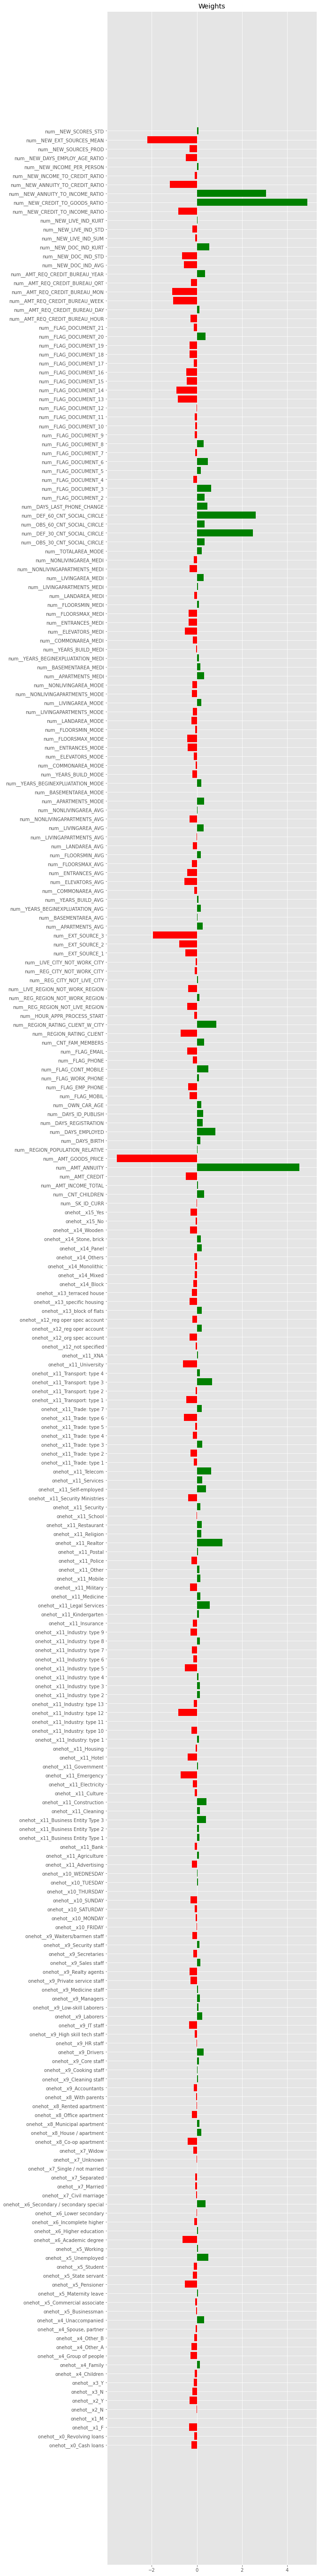

In [77]:
with plt.style.context("ggplot"):
    fig = plt.figure(figsize=(8,100))
    lr =  model_result['lr'][0].best_estimator_
    list_c = model_result['lr'][0].best_estimator_.named_steps['classifier'].coef_[0]
    
    plt.barh(range(len(list_c)), list_c, color=["red" if coef<0 else "green" for coef in list_c])
    plt.yticks(range(len(list_c)), columns);
    plt.title("Weights")
    
plt.savefig('output.png', dpi=300, bbox_inches='tight')

Représentons graphiquement les 10 coefficients positifs et négatifs qui ont le plus large impact sur la régression logistique

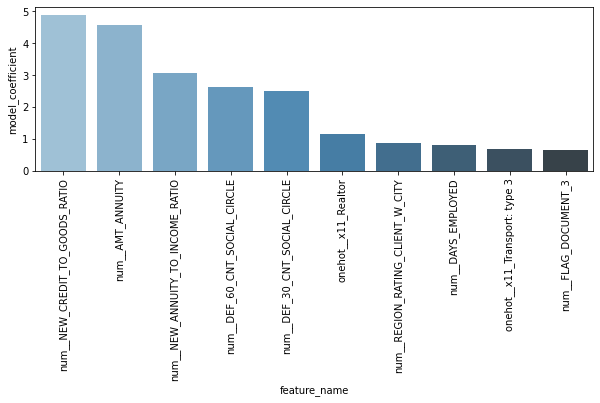

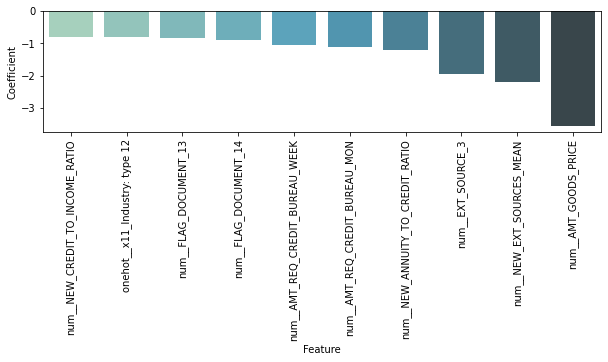

In [78]:
 # Get the models coefficients (and top 5 and bottom 5)
logReg_coeff = pd.DataFrame({'feature_name': columns, 'model_coefficient': model_result['lr'][0].best_estimator_.named_steps['classifier'].coef_[0].transpose().flatten()})
logReg_coeff = logReg_coeff.sort_values('model_coefficient', ascending=False)
logReg_coeff_top = logReg_coeff.head(10)
logReg_coeff_bottom = logReg_coeff.tail(10)
# Plot top 5 coefficients
plt.figure().set_size_inches(10, 6)
fg3 = sns.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_top, palette="Blues_d")
fg3.set_xticklabels(rotation=90, labels=logReg_coeff_top.feature_name)
plt.subplots_adjust(bottom=0.5)
plt.savefig('figure_3.png')
# Plot bottom 5 coefficients
plt.figure().set_size_inches(10,6)
fg4 = sns.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_bottom, palette="GnBu_d")
fg4.set_xticklabels(rotation=90, labels=logReg_coeff_bottom.feature_name)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.subplots_adjust(bottom=0.6)
plt.savefig('figure_4.png')

Ainsi, nous allons calculer le nombre d’Euler à la puissance de son coefficient pour trouver l’importance des features.

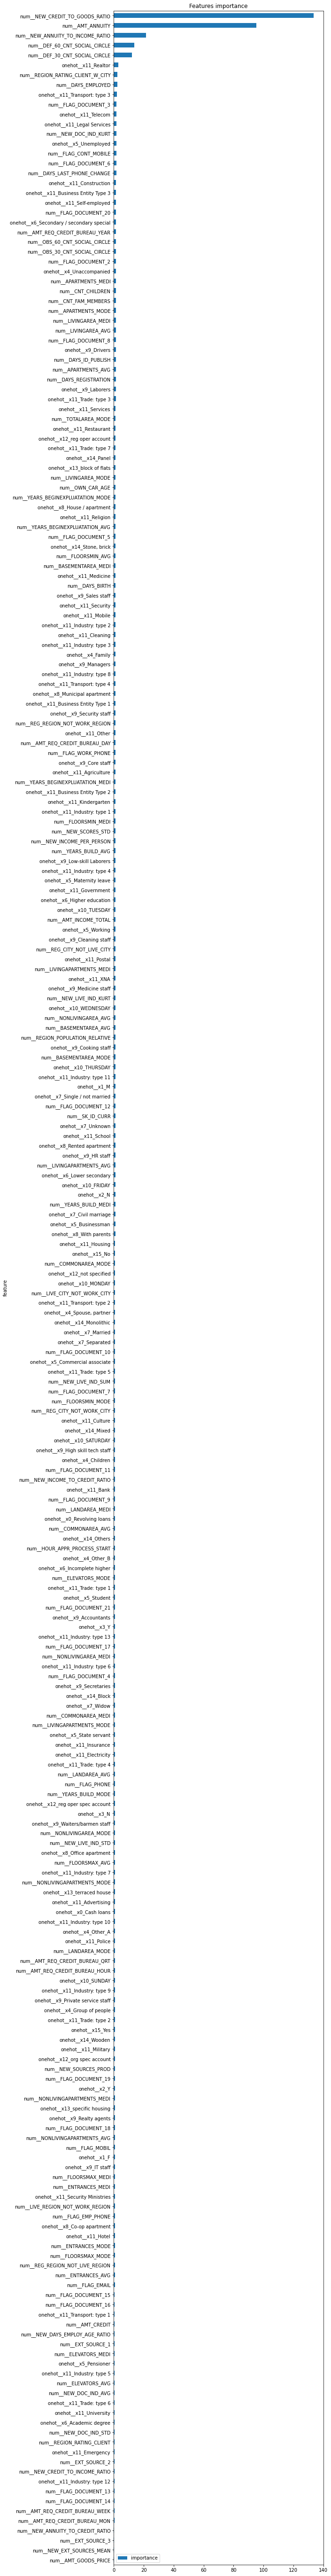

In [88]:
import math
feature_importance = pd.DataFrame(columns, columns = ["feature"])
feature_importance["importance"] = pow(math.e, list_c)
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=True)

 
from sklearn.linear_model import LogisticRegression
ax = feature_importance.plot.barh(x='feature', y='importance', figsize=(8, 100))
plt.title("Features importance")


plt.savefig('features_imp.png', dpi=300, bbox_inches='tight')



Pour résumer, la caractéristique la plus forte dans l’ensemble de données de ce jeu est le ratio new_credit_to_goods_ratio. Une augmentation de ce ratio d’une unité augmente les chances d’être de classe non solvable d’un facteur de 100 lorsque toutes les autres caractéristiques restent les mêmes.



Production du graphique d'importance des variables avec shap. Un graphique d'importance des variables répertorie les variables les plus significatives par ordre décroissant.Les variables du haut contribuent davantage au modèle que les variables du bas et ont donc un pouvoir prédictif élevé.

In [80]:
import shap

shap.initjs()

x_TrainP = model.named_steps['preprocessor'].fit_transform(X_train)

x_TrainR, y_trainR = model.named_steps['sampler'].fit_resample(x_TrainP, y_train)
masker = shap.maskers.Independent(data = x_TrainR)
explainer = shap.LinearExplainer(model.named_steps['classifier'], masker = masker)

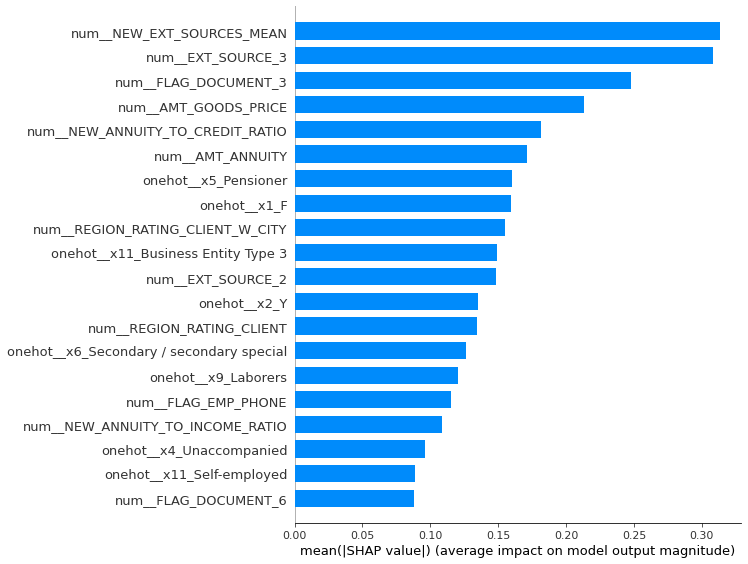

In [81]:
#get Shap values from preprocessed data
shap_values = explainer.shap_values(x_TrainR)

#plot the feature importance
shap.summary_plot(shap_values, x_TrainR, plot_type="bar", feature_names=columns)


Le graphique des valeurs SHAP peut en outre montrer les relations positives et négatives des prédicteurs avec la variable cible.

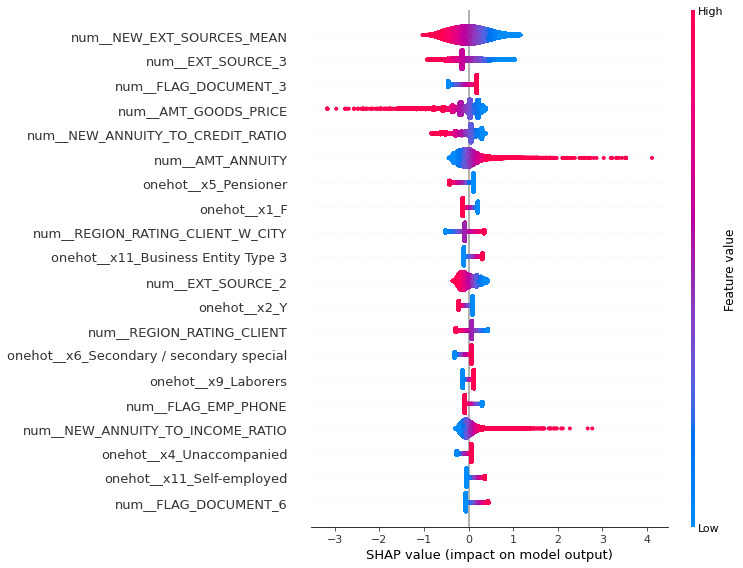

In [82]:
shap.summary_plot(shap_values, x_TrainR, feature_names=columns)


Ce graphique montre :
* Importance de la fonctionnalité: les variables sont classées par ordre décroissant.
* Impact: l'emplacement horizontal indique si l'effet de cette valeur est associé à une prédiction supérieure ou inférieure .
* Valeur d'origine: la couleur indique si cette variable est élevée (en rouge) ou basse (en bleu) pour cette observation.

References:

Reducing Memory usage  - https://www.kaggle.com/gemartin/load-data-reduce-memory-usage

Notebook de référence : https://www.kaggle.com/ganeshn88/home-credit-model